In [3]:
!pip install SPARQLWrapper

In [4]:
import pandas as pd
import json

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt


In [5]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

def sparql_service_to_dataframe_with_scrollable_cursor(service, query_templ, params=(), page_size=10000):
    offset= 0
    keep_going=True
    df_res_list = [] 

    print('fetching... ', end='')
    while True:
        query = query_templ % (params + (offset, page_size) )
        df_res = sparql_service_to_dataframe(service, query )
        if df_res.shape[0] > 0 : 
           print(df_res.shape[0], end=', ')
           df_res_list.append(df_res)
           offset = offset + page_size
        else:
            print(df_res.shape[0])
            break
    return pd.concat(df_res_list)

def hyperlink(val):
    return '<a href="{}">{}</a>'.format(val,val)

def hyperlink_multi(val):
    uris = val.split(', ')
    uris_hl = ['<a href="{}">{}</a>'.format(v,v) for v in uris]

    return ', '.join(uris_hl)

In [6]:
issa_agritrop_endpoint = 'https://data-issa.cirad.fr/sparql'

## Count named entities from all NER tools

In [7]:
entity_count_per_annotator_query = '''
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT ?annotator 
       (count(?entity) as ?cnt) 
	     (count(distinct ?uri) as ?unique_cnt)
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
WHERE {
	?entity a prov:Entity;
          oa:hasBody ?uri;
          prov:wasAttributedTo ?annotator.
}
'''

In [8]:
df_entity_count = sparql_service_to_dataframe(issa_agritrop_endpoint, entity_count_per_annotator_query)

df_entity_count = df_entity_count.astype({'cnt': 'int',
                                          'unique_cnt' : 'int'})

print(df_entity_count.shape)

(4, 3)


In [9]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_entity_count.style.set_table_styles(table_style)

,annotator,cnt,unique_cnt
0,http://data-issa.cirad.fr/DBPediaSpotlight,1553012,67289
1,http://data-issa.cirad.fr/EntityFishing,1634213,59730
2,http://data-issa.cirad.fr/GeographicEntityExtractor,179239,7554
3,http://data-issa.cirad.fr/Pyclinrec,6313524,18034


In [46]:
annotations_per_entity_count_query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {

      SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
      WHERE {

      {
      SELECT ?uri ?annotator
            (count(distinct ?paper) as ?cnt)
            (min(?conf) as ?min_conf)
            (max(?conf) as ?max_conf)

      WHERE {
            ?entity a prov:Entity;
            oa:hasBody ?uri;
            schema:about ?paper;
            issapr:confidence ?conf;
            prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec
            }
      GROUP by  ?uri ?annotator
      }
      
      OPTIONAL {
            ?uri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      # for DBPedia.fr
      OPTIONAL {
            ?uri rdfs:label ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      OPTIONAL {
            # |gn:alternateName||gn:shortName
            ?uri gn:name ?entityLabel_nolang.
      }
      
            BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
      }
      ORDER BY DESC(?cnt)
}
OFFSET %d
LIMIT %d
'''

In [11]:
annotators = {'wikidata': 'issa:EntityFishing',
              'geonames': 'issa:GeographicEntityExtractor',
              'dbpedia' : 'issa:DBPediaSpotlight',
              'agrovoc' : 'issa:Pyclinrec'}

In [54]:
# in some queries having a long choice of paths to a label proves to be too expensive. 
# For these queries we can split the path and pass it as a string substitution.
label_path = {'wikidata': 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'geonames': 'gn:officialName',
              'dbpedia' : 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'agrovoc' : 'skosxl:prefLabel/skosxl:literalForm'}

## Annotation quality assesment per vocabulary
Select one of the vocabularis and run the cells below

In [200]:
vocab = 'agrovoc'

In [201]:
df_ne_count = {}
#for key, value in annotators.items():
key, value = vocab, annotators[vocab]
df_ne_count[key] = sparql_service_to_dataframe_with_scrollable_cursor(issa_agritrop_endpoint,  annotations_per_entity_count_query, (value, ) )
df_ne_count[key].dropna(inplace=True)
df_ne_count[key] = df_ne_count[key].astype({'cnt': 'int',
                                            'min_conf' : 'float',
                                            'max_conf' : 'float'})
print(annotators[key] , df_ne_count[key].shape)

fetching... 10000, 8034, 0
issa:Pyclinrec (18032, 5)


In [202]:
#import pickle
#with open('df_ne_count.pkl', 'wb') as f:
#    pickle.dump(df_ne_count, f)

#with open('df_ne_count.pkl', 'rb') as f:
#    df_ne_count = pickle.load(f)

In [203]:
df_ne_count[vocab].describe() \
                  .transpose() \
                  .style.format(precision=2)\
                  .set_table_styles(table_style) 

,count,mean,std,min,25%,50%,75%,max
cnt,18032.00,111.08,450.23,1.00,2.00,8.00,37.00,8882.00
min_conf,18032.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
max_conf,18032.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


OBSERVATIONS: 
- AGROVOC: Confidence score is always 1.0. It should be addressed in the *pyclinrec* library.
- GEONAMES: 
- WIKIDATA: we don't filter the wikidata NE but we probably should as min confidence is 0.35.
- DBPEDIA: we do filter the DBpedia NEs by setting up the Spotlight parameters, terefore the min confidence is 0.75. Otherwise there would be a lot of NEs.

### Most popular entities 

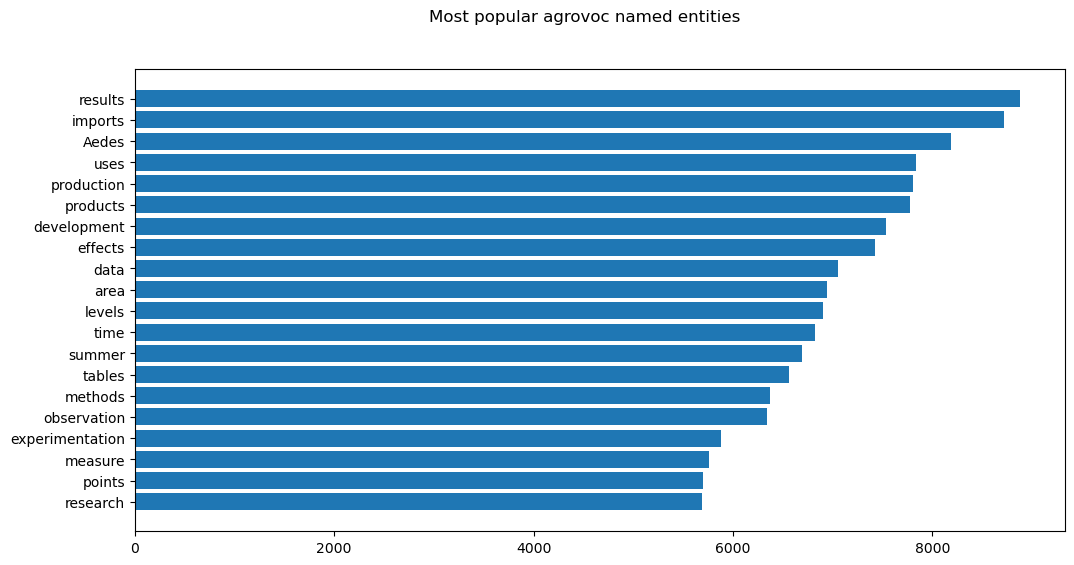

In [204]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle(f'Most popular {vocab} named entities')

plt.barh(df_ne_count[vocab].head(20).entityLabel , width= df_ne_count[vocab].head(20).cnt)
plt.gca().invert_yaxis()

plt.show()

OBSERVATIONS: 
- AGROVOC: the 3-rd concept *Aedes* is spanned from the English article *A*. It will be removed by filtering out very short text (<3 letters) annotation.  
- GEONAMES: as expected 
- WIKIDATA: as expected the top named entities are wither geographic or agriculture related.
- DBPAEDIA: not as agricultural as wikidata. Odd one: *Seconde Guerre Mondiale*.

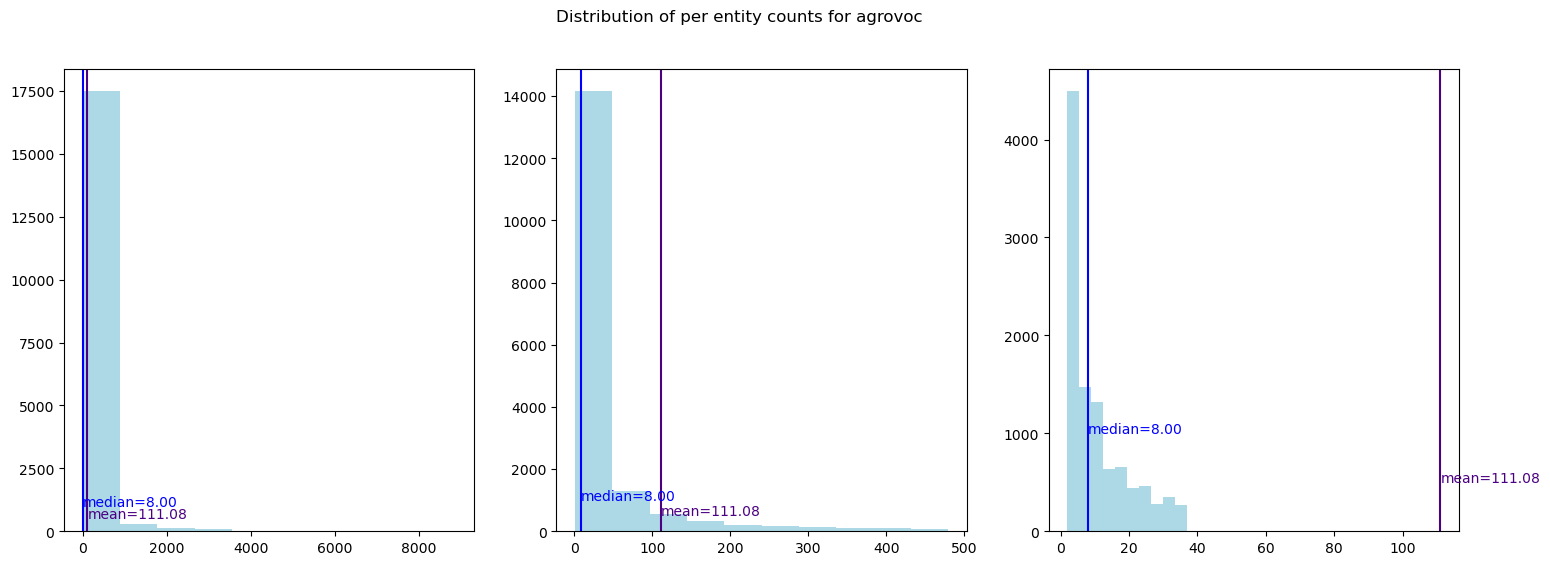

In [205]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle(f'Distribution of per entity counts for {vocab}')

def show_hist(i, df_f1, range=None):
    mean_cnt = df_f1.cnt.mean()
    median_cnt = df_f1.cnt.median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df_f1.cnt, 10, color='lightblue', range=range)
    plt.axvline(mean_cnt, color='indigo')
    plt.text(mean_cnt + 0.01, 500, 'mean=%.2f' % mean_cnt , color="indigo")

    plt.axvline(median_cnt, color="blue")
    plt.text(median_cnt + 0.01, 1000, 'median=%.2f' % median_cnt , color="blue")


show_hist(0, df_ne_count[vocab])
show_hist(1, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.05) ,  df_ne_count[vocab].cnt.quantile(0.95)) )
show_hist(2, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.25) ,  df_ne_count[vocab].cnt.quantile(0.75)) )

### Missing labels

In [206]:
df_ne_count[vocab][df_ne_count[vocab].entityLabel.isna()]\
    .style.format({'uri': hyperlink})

,uri,entityLabel,cnt,min_conf,max_conf


OBSERVATIONS: 
- AGROVOC: both categories are depricated. Evidently the annotation was done before local Agrovoc update.
- GEONAMES:
- WIKIDATA:
- DBPEDIA:

### Named entities recognised from a short text

In [207]:
short_text_query_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {
      {SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {
            #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ?surfaceLEN %s )
            } 
      GROUP BY ?surface ?entityUri ?entityLabel
      }
      OPTIONAL {
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri %s ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      OPTIONAL {
            ?entityUri %s ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      OPTIONAL {
            ?entityUri gn:name ?entityLabel_nolang.
      }

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}
ORDER BY ?surface ?entityLabel
'''

In [208]:
df_short_text_count = {}

df_short_text_count[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                            short_text_query_templ %  (annotators[vocab], '< 4',
                                                                                       label_path[vocab], label_path[vocab]) )
df_short_text_count[vocab] = df_short_text_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(annotators[vocab] , df_short_text_count[vocab].shape)

issa:Pyclinrec (1528, 7)


#### len(surface) == 1

In [209]:
df_short_text_1 =  df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 1]

#df_short_surface_1.sort_values(by='cnt', ascending=False)
df_short_text_1.sort_values(by=['entityLabel_en','cnt'])\
                  #.style.set_table_styles(table_style)

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
39,1,A,Aedes,Aedes,Aedes,http://aims.fao.org/aos/agrovoc/c_146,31157


CONCLUSIONS: 
- AGROVOC: definetely have to filter out the entities for one letter surface 'A' (0.4% of all )
- GEONAMES:
- WIKIDATA:  the filter the short text annotations (< 3 letters>) in Mongodb script. This idea had been transfered from the COTW project. I don't know if the data was analysed  beforehand. 
- DBPEDIA: same 

#### len(surface) == 2

In [210]:
pd.options.display.max_rows = 10
df_short_surface_2 =  df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 2]

#df_short_surface_2.sort_values(by='cnt', ascending=False)
df_short_surface_2.sort_values(by=['entityLabel_en','cnt'])\
                  #.style.format({'entityUri': hyperlink})

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
1042,2,ba,6-benzylaminopurine,6-benzyladenine,6-benzylaminopurine,http://aims.fao.org/aos/agrovoc/c_754,22
209,2,Ba,6-benzylaminopurine,6-benzyladenine,6-benzylaminopurine,http://aims.fao.org/aos/agrovoc/c_754,63
188,2,BA,6-benzylaminopurine,6-benzyladenine,6-benzylaminopurine,http://aims.fao.org/aos/agrovoc/c_754,101
1488,2,uA,AU,UA,AU,http://aims.fao.org/aos/agrovoc/c_331313,1
967,2,aU,AU,UA,AU,http://aims.fao.org/aos/agrovoc/c_331313,7
...,...,...,...,...,...,...,...
904,2,Tp,total phosphorus,phosphore total,total phosphorus,http://aims.fao.org/aos/agrovoc/c_ac4b3c22,8
886,2,TP,total phosphorus,phosphore total,total phosphorus,http://aims.fao.org/aos/agrovoc/c_ac4b3c22,133
1312,2,oU,wadi,oued,wadi,http://aims.fao.org/aos/agrovoc/c_24124,1
662,2,OU,wadi,oued,wadi,http://aims.fao.org/aos/agrovoc/c_24124,38


CONCLUSION: 
- AGROVOC: the 2 letter surface also does not match very well with the exceptions of UK, EU, and pH. I think they should be filtered as well (0.4% of all).
- GEONAMES: hard to tell, some of the 2 letter entities look ok, like *UK* or *US* but some are quesionable like *LA* or *SC*. Removing these entities would mean removing 4% of annottaions. Definetely needs a closer look.
- WIKIDATA: see the conclusion above
- DBPEDIA: see the conclusion  above

#### len(surface) == 3

In [211]:
pd.options.display.max_rows = 10
df_short_text_3 =  df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 3]

#df_short_text_3.sort_values(by='cnt', ascending=False)
df_short_text_3.sort_values(by=['entityLabel_en','cnt'])\
               #.style.format({'entityUri': hyperlink})

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
26,3,4-2,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,9
28,3,4-4,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,9
23,3,4 4,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,11
13,3,2-2,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,17
21,3,4 2,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,24
...,...,...,...,...,...,...,...
1153,3,fil,yarns,fils,yarns,http://aims.fao.org/aos/agrovoc/c_706170e4,544
957,3,Yaw,yawing,None,yawing,http://aims.fao.org/aos/agrovoc/c_f82f3fe2,1
960,3,ZOO,zoos,zoo,zoos,http://aims.fao.org/aos/agrovoc/c_8531,1
963,3,Zoo,zoos,zoo,zoos,http://aims.fao.org/aos/agrovoc/c_8531,83


##### surface text starts with digit

In [212]:
pd.options.display.max_rows = 10
df_short_text_count[vocab] .loc[df_short_text_count[vocab] .surface.str[0].str.isdigit() ]\
                  #.style.format({'entityUri': hyperlink})  

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
3,3,1 1,Goal 1 No poverty,Objectif 1 Pas de pauvreté,Goal 1 No poverty,http://aims.fao.org/aos/agrovoc/c_565dbc68,116
4,3,1 1,photosystem I,photosystème i,photosystem I,http://aims.fao.org/aos/agrovoc/c_34952,609
5,3,1-1,Goal 1 No poverty,Objectif 1 Pas de pauvreté,Goal 1 No poverty,http://aims.fao.org/aos/agrovoc/c_565dbc68,14
6,3,1-1,photosystem I,photosystème i,photosystem I,http://aims.fao.org/aos/agrovoc/c_34952,66
7,3,2 2,"2,4-D","2,4-d","2,4-D",http://aims.fao.org/aos/agrovoc/c_8543,34
...,...,...,...,...,...,...,...
34,3,6 6,Goal 6 Clean water and sanitation,Objectif 6 Eau propre et assainissement,Goal 6 Clean water and sanitation,http://aims.fao.org/aos/agrovoc/c_d972c36a,1
35,3,6-6,6-benzylaminopurine,6-benzyladenine,6-benzylaminopurine,http://aims.fao.org/aos/agrovoc/c_754,1
36,3,7 7,Goal 7 Affordable and clean energy,Objectif 7 Énergie propre et d’un coût abordable,Goal 7 Affordable and clean energy,http://aims.fao.org/aos/agrovoc/c_e2aa372f,3
37,3,8 8,Goal 8 Decent work and economic growth,Objectif 8 Travail décent et croissance économiqu,Goal 8 Decent work and economic growth,http://aims.fao.org/aos/agrovoc/c_3b312ffd,1


CONCLUSION: 
- AGROVOC:  in 3 letters surface there are 36 cases that start with diigits and definetely not well annotated 
- GEONAMES: the text *7E* annotated as  *Paris 07 Palais-Bourbon* is most likely junk. But having one junky annotation is is very insignificant.
- WIKIDATA: Consider filtering out the short text that starts with a digit.
- DBPEDIA: the same as above

##### surface matches the entity label

In [213]:
pd.options.display.max_rows = 10

def unCapitalise(s):
     if s[0].isupper() and s[1].islower():
          return s[:1].lower() + s[1:]
     else:
          return s


df_short_text_3.loc[(df_short_text_3.surface.apply(unCapitalise) == df_short_text_3.entityLabel_en) | 
                       (df_short_text_3.surface.apply(unCapitalise) == df_short_text_3.entityLabel_fr)] \
                  .sort_values(by=['entityLabel_en','cnt'])\
                  #.style.format({'entityUri': hyperlink}) 

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
80,3,ABA,ABA,ABA,ABA,http://aims.fao.org/aos/agrovoc/c_3,261
85,3,ACP,ACP,ACP,ACP,http://aims.fao.org/aos/agrovoc/c_24811,765
95,3,ADP,ADP,ADP,ADP,http://aims.fao.org/aos/agrovoc/c_123,26
111,3,AMP,AMP,AMP,AMP,http://aims.fao.org/aos/agrovoc/c_124,15
126,3,ATP,ATP,ATP,ATP,http://aims.fao.org/aos/agrovoc/c_125,137
...,...,...,...,...,...,...,...
1505,3,vin,wines,vin,wines,http://aims.fao.org/aos/agrovoc/c_8406,149
756,3,Pic,woodpeckers,pic,woodpeckers,http://aims.fao.org/aos/agrovoc/c_8434,9
1385,3,pic,woodpeckers,pic,woodpeckers,http://aims.fao.org/aos/agrovoc/c_8434,321
963,3,Zoo,zoos,zoo,zoos,http://aims.fao.org/aos/agrovoc/c_8531,83


CONCLUSION: 
- AGROVOC: in 3 letter surface texts where the entity is an exact match to the surface text the annotations are correct (1.7%). However when they are not matched after a cursory look I see that the annotations are quite dirty (2.4%). If we filter out all of the annotations of 3 letters we may loose less than 2% of good annoatations. 
- GEONAMES: geonames labels try to expand the abrreviations that's why there is no match between 3 letter text and concept lables.
- WIKIDATA: hard to judge the abbreviations. but not abbreaviate 3 letter text looks good.
- DBPEDIA: the same

### Multiple entities for one piece of text

#### More than 4 named entity per text

In [214]:
multiple_entities_query_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>


SELECT ?source ?surface ?start ?cnt 
       #?entities 
WHERE {
  { SELECT ?source ?surface ?start 
          (count(?entityUri) as ?cnt)
          (group_concat(?entityUri; separator=", ") as ?entities) 
    WHERE {
          #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
          ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  prov:wasAttributedTo ?annotator.
          FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

          ?selector oa:exact ?surface;
                    oa:start ?start.
          } 
    GROUP BY ?source ?surface ?start
    HAVING (count(?entityUri) %s )
  }

}
order by desc(?cnt)
'''

In [215]:
df_multi_entities = {}

df_multi_entities[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                        multiple_entities_query_templ %  (annotators[vocab], '> 4') )

df_multi_entities[vocab] = df_multi_entities[vocab].astype({'cnt': 'int'})
print(annotators[vocab] , df_multi_entities[vocab].shape)

issa:Pyclinrec (971, 4)


In [216]:
df_multi_entities[vocab]\
    #.style.format({'source': hyperlink})

,source,surface,start,cnt
0,http://data-issa.cirad.fr/article/592930#body_...,plant-plant,4047,227
1,http://data-issa.cirad.fr/article/595504#body_...,plant through plant,20034,227
2,http://data-issa.cirad.fr/article/579316#body_...,plants planted,3408,227
3,http://data-issa.cirad.fr/article/517953#body_...,planting plants,10782,227
4,http://data-issa.cirad.fr/article/591187#body_...,plant-plant,13322,227
...,...,...,...,...
966,http://data-issa.cirad.fr/article/581909#body_...,hand in hand,607,5
967,http://data-issa.cirad.fr/article/601371#body_...,vectors through vector,783,5
968,http://data-issa.cirad.fr/article/457647#body_...,divi-divi,4224,5
969,http://data-issa.cirad.fr/article/457647#body_...,divi-divi,2916,5


In [217]:
# Complementary query: get all the entities for a specific text

entities_for_surface_query_templ = ''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?source ?start ?surface ?entityUri ?entityLabel_en ?entityLabel_fr
WHERE 
{
    VALUES (?source) {(<%s>)}
    VALUES (?start) {(%d)}
    
    ?entity a prov:Entity;
            oa:hasBody ?entityUri;       
            oa:hasTarget/oa:hasSelector ?selector;
            oa:hasTarget/oa:hasSource ?source;
            prov:wasAttributedTo ?annotator.
    FILTER (?annotator = %s)

    ?selector oa:exact ?surface;
              oa:start ?start.

    OPTIONAL {
        ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_en.
        FILTER langMatches(lang(?entityLabel_en), "en" )  }

	OPTIONAL {
	    ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_fr.
        FILTER langMatches(lang(?entityLabel_fr), "fr" ) }
}
'''

# copy/paste the values for this query here: 
source = 'http://data-issa.cirad.fr/article/592930#body_text'
start  = 4047

df_nes = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                    entities_for_surface_query_templ %  (source, start, annotators[vocab]) )
print(df_nes.shape)
df_nes

(227, 6)


,source,start,surface,entityUri,entityLabel_en,entityLabel_fr
0,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_13439,plant structure,structure des plantes
1,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_15503,Impatiens,Impatiens
2,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_1720,Coffea,Coffea
3,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_2300,Dioscoreaceae,Dioscoreaceae
4,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_1972,crops,plante de culture
...,...,...,...,...,...,...
222,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_9312,blasts (of plants),None
223,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_ec319441,vegetal fossils,None
224,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_8d406570,submerged aquatic plants,None
225,http://data-issa.cirad.fr/article/592930#body_...,4047,plant-plant,http://aims.fao.org/aos/agrovoc/c_f719a413,emergent aquatic plants,None


CONCLUSION: 
- AGROVOC: There is a quite large number of overlaping entities. And it seems that the majority of the overlapping NEs are for the texts that has repetitive words in surface form. Considering that this issue can produce up to 227 extra annottaions we need to find the way to either fix it in the library or filter them out.
- GEONAMES: no overapping.
- WIKIDATA: no overapping.
- DBPEDIA: no overalpping.

#### 4 (or less) entities for one piece of text 

In [218]:
multiple_entities_query_templ_4 = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>


#SELECT ?source ?surface ?start ?cnt #?entities
SELECT ?surface  (count(?source) as ?super_cnt)  ?entities
WHERE {
  { SELECT ?source ?surface ?start 
          (count(?entityUri) as ?cnt)
          (group_concat(?entityUri; separator=", ") as ?entities) 
    WHERE {
          ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  prov:wasAttributedTo ?annotator.
          FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

          ?selector oa:exact ?surface;
                    oa:start ?start.

    } 
    GROUP BY ?source ?surface ?start
    HAVING (count(?entityUri) %s )
    }

}
group by ?surface ?entities
#order by desc(?cnt)
#limit 100
'''

In [219]:
df_multi_entities_4 = {}

df_multi_entities_4[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                        multiple_entities_query_templ_4 %  (annotators[vocab], '= 4') )

df_multi_entities_4[vocab] = df_multi_entities_4[vocab].astype({'super_cnt': 'int'})
print(annotators[vocab] , df_multi_entities_4[vocab].shape)

issa:Pyclinrec (116, 3)


In [220]:
# Complementary query because adding the label fetching in the main query makes its execution too long
labels_for_uris_query_templ = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

SELECT *
WHERE {

    VALUES(?entityUri) { %s }

    OPTIONAL {
        ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_en.
        FILTER langMatches(lang(?entityLabel_en), "en" )  }

	OPTIONAL {
	    ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_fr.
        FILTER langMatches(lang(?entityLabel_fr), "fr" ) }

}

'''
def decorate_uris_multi(val):
    uris = val.split(', ')
    uris_d = ['(<{}>)'.format(v) for v in uris]

    return ' '.join(uris_d)

def fetch_entity_labels(entityUris):
    return sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                        labels_for_uris_query_templ % decorate_uris_multi(entityUris)  )

def entity_labels(entityUris):
    df_lbls = fetch_entity_labels(entityUris)
    df_lbls.fillna('', inplace=True)
    return [', '.join(df_lbls.entityLabel_en) ,  ', '.join(df_lbls.entityLabel_fr)]

s_lbls = df_multi_entities_4[vocab].entities.apply(entity_labels)
df_multi_entities_4[vocab]['labels_en']=s_lbls.apply(lambda x: x[0])
df_multi_entities_4[vocab]['labels_fr']=s_lbls.apply(lambda x: x[1])


In [221]:
# two different ways to visualize the table, uncomment the prefered way

idx = ['entities', df_multi_entities_4[vocab].index ]
df_multi_entities_4[vocab].set_index(idx)\
                          .sort_values(by=['entities', 'surface'])

#df_multi_entities_4[vocab].sort_values(by=['entities', 'surface'])\
#    .style.format({'entities': hyperlink_multi})                          

surface  \
entities                                                                      
http://aims.fao.org/aos/agrovoc/c_016fddeb, htt... 110                  C C   
                                                   6                    C c   
                                                   14                   C-C   
                                                   113                  c C   
                                                   44                   c c   
...                                                                     ...   
http://aims.fao.org/aos/agrovoc/c_6539, http://... 109         vitamination   
                                                   86              vitamine   
                                                   13             vitamines   
                                                   104             vitamins   
http://aims.fao.org/aos/agrovoc/c_ac4b3c22, htt... 52   Phosphore Phosphore   

                                                        super_cnt  \
entities                                                            
http://aims.fao.org/aos/agrovoc/c_016fddeb, htt... 110          1   
                                                   6            8   
                                                   14           5   
                                                   113          1   
                                                   44           8   
...                                                           ...   
http://aims.fao.org/aos/agrovoc/c_6539, http://... 109          1   
                                                   86         335   
                                                   13         218   
                                                   104          5   
http://aims.fao.org/aos/agrovoc/c_ac4b3c22, htt... 52           1   

                                                                                                labels_en  \
entities                                                                                                    
http://aims.fao.org/aos/agrovoc/c_016fddeb, htt... 110    ascorbic acid, cytochrome C, C horizons, carbon   
                                                   6      ascorbic acid, cytochrome C, C horizons, carbon   
                                                   14     ascorbic acid, cytochrome C, C horizons, carbon   
                                                   113    ascorbic acid, cytochrome C, C horizons, carbon   
                                                   44     ascorbic acid, cytochrome C, C horizons, carbon   
...                                                                                                   ...   
http://aims.fao.org/aos/agrovoc/c_6539, http://... 109        ascorbic acid, retinol, vitamins, vitamin D   
                                                   86         ascorbic acid, retinol, vitamins, vitamin D   
                                                   13         ascorbic acid, retinol, vitamins, vitamin D   
                                                   104        ascorbic acid, retinol, vitamins, vitamin D   
http://aims.fao.org/aos/agrovoc/c_ac4b3c22, htt... 52   total phosphorus, phosphorus isotopes, organic...   

                                                                                                labels_fr  
entities                                                                                                   
http://aims.fao.org/aos/agrovoc/c_016fddeb, htt... 110  acide ascorbique, cytochrome c, horizon c, car...  
                                                   6    acide ascorbique, cytochrome c, horizon c, car...  
                                                   14   acide ascorbique, cytochrome c, horizon c, car...  
                                                   113  acide ascorbique, cytochrome c, horizon c, car...  
                                                   44   acide ascorbique, cy

CONCLUSION: 
- AGROVOC: (1) the same issues as with higher counts (2) many instances of multiple entities are stemmed from the same text, for example for *product* there are always 4 entities recognised *products, by-products, production, productivity*. I suppose this is ok. 
- GEONAMES: no overalping :thumbsup
- WIKIDATA: no overalping :thumbsup
- DBPEDIA: no overalping :thumbsup


### Surface forms that begin with non-letters

In [222]:
text_starts_with_non_letter_query_templ = ''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <http://data-issa.cirad.fr/property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {
      {SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {
            #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = %s) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ! REGEX(?surface, "^[a-z,A-Z,À-ÿ]")  ) # Greek letters ,\\p{Greek},µ
            } 
      GROUP BY ?surface ?entityUri ?entityLabel
      }
      OPTIONAL {
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri %s ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }
      OPTIONAL {
            ?entityUri %s ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }
      # for Geonames
      OPTIONAL {
            ?entityUri gn:name ?entityLabel_nolang.
      }

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}
ORDER BY ?surface ?entityLabel
'''

In [223]:
df_non_letter_count = {}

df_non_letter_count[vocab] = sparql_service_to_dataframe(issa_agritrop_endpoint,  
                                                            text_starts_with_non_letter_query_templ %  (annotators[vocab],
                                                                                       label_path[vocab], label_path[vocab]) )
df_non_letter_count[vocab] = df_non_letter_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(annotators[vocab] , df_non_letter_count[vocab].shape)

issa:Pyclinrec (208, 7)


In [224]:
df_non_letter_count[vocab].sort_values(by=['surface'])\
                  #.style.format({'entityUri': hyperlink})
                  

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
0,10,'Agronomie,agronomy,agronomie,agronomy,http://aims.fao.org/aos/agrovoc/c_211,1
1,12,'Anthracnose,anthracnosis,anthracnose,anthracnosis,http://aims.fao.org/aos/agrovoc/c_481,1
2,3,'ER,Vicia ervilia,Vicia ervilia,Vicia ervilia,http://aims.fao.org/aos/agrovoc/c_8219,2
3,12,'Exportation,exports,exportation,exports,http://aims.fao.org/aos/agrovoc/c_2761,1
4,7,'Ivoire,ivory,ivoire,ivory,http://aims.fao.org/aos/agrovoc/c_16373,1
...,...,...,...,...,...,...,...
203,19,6-benzylaminopurine,6-benzylaminopurine,6-benzyladenine,6-benzylaminopurine,http://aims.fao.org/aos/agrovoc/c_754,3
204,3,7 7,Goal 7 Affordable and clean energy,Objectif 7 Énergie propre et d’un coût abordable,Goal 7 Affordable and clean energy,http://aims.fao.org/aos/agrovoc/c_e2aa372f,3
205,8,7 of SDG,Goal 7 Affordable and clean energy,Objectif 7 Énergie propre et d’un coût abordable,Goal 7 Affordable and clean energy,http://aims.fao.org/aos/agrovoc/c_e2aa372f,1
206,3,8 8,Goal 8 Decent work and economic growth,Objectif 8 Travail décent et croissance économiqu,Goal 8 Decent work and economic growth,http://aims.fao.org/aos/agrovoc/c_3b312ffd,1


In [225]:
df_non_letter_count[vocab].loc[(df_non_letter_count[vocab].surfaceLen==4) & 
                              ( df_non_letter_count[vocab].entityLabel_fr.str.isdigit()) ].cnt.sum()


0

In [226]:
df_non_letter_count[vocab].head()

,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
0,10,'Agronomie,agronomy,agronomie,agronomy,http://aims.fao.org/aos/agrovoc/c_211,1
1,12,'Anthracnose,anthracnosis,anthracnose,anthracnosis,http://aims.fao.org/aos/agrovoc/c_481,1
2,3,'ER,Vicia ervilia,Vicia ervilia,Vicia ervilia,http://aims.fao.org/aos/agrovoc/c_8219,2
3,12,'Exportation,exports,exportation,exports,http://aims.fao.org/aos/agrovoc/c_2761,1
4,7,'Ivoire,ivory,ivoire,ivory,http://aims.fao.org/aos/agrovoc/c_16373,1


In [227]:
df_non_letter_count[vocab].cnt.sort_values().sum()

2017

CONCLUSIONS:
- AGROVOC: a very few surface forms begin with non-alphabetical characters (208 unique and 2017 annotations in total (~0.02% from all annotations)) - 18 start with an apostrophe and the rest with digits. The first group has ligit annotation but wrong offsets, the second presents "dirty" annotations. Although the number is low we can try to filter them out. 
- GEONAMES: 24 surface forms that start with various non-alphabetical and non-digit characters. Some of the annotations look ok though but the offsets are incorrect. Si I think it would be better to filter them out too and we will not loose much of the information.
- WIKIDATA: about 1% of entity-fishing annotatins correspond to the text that begins with non-alphabetical charachters. In most cases they are interpreded as :
    - country calling codes - e.g. *+223*	= *Telephone numbers in Mali* - correct and clever but irrelevant for the corpus
    - file extensions - e.g. *.csv file*	= *comma-separated values* - also correct and clever but irrelevant
    - quantity  annotations - e.g. *0.31%* = 	*1998 United States Senate elections* - mosly meaningless
    - dates - e.g. *01/09* = *September 1* - correct but not interesting I suppose
    - chemical formulas - e.g. *1-MCP* = *1-methylcyclopropene*  - these could be good to keep but hard to distinguish
    - biological nmaes  - e.g. *β2-microglobulin* = *Beta-2-microglobulin*  - these could be good to keep and if they begin with a greek letter easy to do
    - units - e.g. *μmol* = *mole* - also good to keep
    
    It looks like majority of annotations for the text starting with digit is meaningless and can be filtered out we would only loose the chemical and biological entities along the way. Other starting charactes are ok including the greek letters.
- DBPEDIA: 2.5% of dbpedia spotlight annotatins correspond to the text that begins with non-alphabetical charachters. Quite a lot! And it seems that the 70% of them are the annotations of the years in french dbpedia. The other issues are similar to wikidata case. Thus if we filter out the annotatins for the surface form starting with non-alphabetical character in te worse case scenario we would loose less than 0.5% of good annotations.  

